# Vehicle Insurance Customer Segmentation

## Project Objective

The goal of this project is to segment vehicle insurance customers using unsupervised learning techniques, specifically clustering algorithms. By analyzing customer demographics, vehicle characteristics, insurance claim behavior, and risk factors, we aim to identify distinct customer groups.

This segmentation will help in:
- Personalizing marketing strategies
- Tailoring insurance products
- Identifying high-risk profiles for proactive risk management
- Enhancing customer retention and satisfaction

We will also perform thorough data cleaning and preprocessing, including handling missing values and skewed data, to ensure reliable clustering results.

# Import Neccessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

# Load Dataset

In [2]:
data = pd.read_csv('vehicle_insurance_customers.csv')
data.drop(columns=["Customer_ID"], inplace=True)
data.head()

,Age,Gender,Driving_Experience,Vehicle_Type,Vehicle_Age,Region_Code,Annual_Premium,Policy_Tenure,Previous_Claims,Accidents_Reported,Claim_Amount_Last_Year,Vehicle_Damage,High_Risk
0,51.0,Male,50.0,Hatchback,11,40,329.49,6,1,0,133.20,No,0
1,55.0,Female,8.0,Hatchback,1,24,330.78,10,0,0,279.98,No,0
2,33.0,Male,14.0,Hatchback,8,43,362.75,4,1,0,464.00,Yes,0
3,18.0,Male,28.0,SUV,12,3,366.53,5,1,0,561.54,No,0
4,58.0,Female,36.0,Sedan,14,1,373.23,7,0,0,12.54,No,0


# Fixing Inconsistent Driving Experience

While exploring the dataset, we noticed some logical inconsistencies in the `Driving_Experience` column.

For example:
- A customer aged 18 with 28 years of driving experience
- Another customer aged 51 with 50 years of driving experience

These scenarios are impossible, as legal driving age is typically 16 or older.

In [3]:
# Display rows where Driving Experience > (Age - 16)
invalid_experience = data[data['Driving_Experience'] > (data['Age'] - 16)]

print(f"Number of rows with invalid driving experience: {len(invalid_experience)}")

Number of rows with invalid driving experience: 12286


In [4]:
invalid_experience[['Age', 'Driving_Experience']]

,Age,Driving_Experience
0,51.0,50.0
3,18.0,28.0
11,18.0,37.0
13,26.0,37.0
15,42.0,41.0
...,...,...
29980,39.0,38.0
29981,18.0,20.0
29982,51.0,44.0
29990,45.0,30.0


In [5]:
# Fix Driving Experience column
def fix_driving_experience(row):
    if pd.isnull(row['Age']) or pd.isnull(row['Driving_Experience']):
        return row['Driving_Experience']
    max_experience = max(0, row['Age'] - 16)
    return min(row['Driving_Experience'], max_experience)

data['Driving_Experience'] = data.apply(fix_driving_experience, axis=1)

In [6]:
data.head()

,Age,Gender,Driving_Experience,Vehicle_Type,Vehicle_Age,Region_Code,Annual_Premium,Policy_Tenure,Previous_Claims,Accidents_Reported,Claim_Amount_Last_Year,Vehicle_Damage,High_Risk
0,51.0,Male,35.0,Hatchback,11,40,329.49,6,1,0,133.20,No,0
1,55.0,Female,8.0,Hatchback,1,24,330.78,10,0,0,279.98,No,0
2,33.0,Male,14.0,Hatchback,8,43,362.75,4,1,0,464.00,Yes,0
3,18.0,Male,2.0,SUV,12,3,366.53,5,1,0,561.54,No,0
4,58.0,Female,36.0,Sedan,14,1,373.23,7,0,0,12.54,No,0


## Vehicle Age vs Customer Age

In [7]:
# Check if Vehicle_Age is greater than Customer_Age
suspicious_vehicle_age = data[data['Vehicle_Age'] > data['Age']]

print(f"Number of records where Vehicle_Age > Age: {suspicious_vehicle_age.shape[0]}")
display(suspicious_vehicle_age[['Age', 'Vehicle_Age']].head())

Number of records where Vehicle_Age > Age: 0


,Age,Vehicle_Age


# Exploratory Data Analysis (EDA)

## Overview of the Dataset

In [8]:
# Check dataset shape
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

# Check column data types and missing values
print(data.info())

# Summary statistics
data.describe()

Dataset contains 30000 rows and 13 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     28500 non-null  float64
 1   Gender                  30000 non-null  object 
 2   Driving_Experience      28500 non-null  float64
 3   Vehicle_Type            30000 non-null  object 
 4   Vehicle_Age             30000 non-null  int64  
 5   Region_Code             30000 non-null  int64  
 6   Annual_Premium          28500 non-null  float64
 7   Policy_Tenure           30000 non-null  int64  
 8   Previous_Claims         30000 non-null  int64  
 9   Accidents_Reported      30000 non-null  int64  
 10  Claim_Amount_Last_Year  28500 non-null  float64
 11  Vehicle_Damage          28500 non-null  object 
 12  High_Risk               30000 non-null  int64  
dtypes: float64(4), int64(6), object(3)
memory usage

,Age,Driving_Experience,Vehicle_Age,Region_Code,Annual_Premium,Policy_Tenure,Previous_Claims,Accidents_Reported,Claim_Amount_Last_Year,High_Risk
count,28500.000000,28500.000000,30000.000000,30000.000000,28500.000000,30000.000000,30000.000000,30000.000000,28500.000000,30000.000000
mean,44.024982,17.752702,7.483467,25.709633,399.987355,4.970800,0.503533,0.302567,495.429647,0.100000
std,15.177808,12.157289,4.611822,14.475007,100.118270,3.162522,0.712183,0.551812,496.045090,0.300005
min,18.000000,0.000000,0.000000,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,8.000000,3.000000,13.000000,331.917500,2.000000,0.000000,0.000000,142.137500,0.000000
50%,44.000000,16.000000,7.000000,26.000000,399.810000,5.000000,0.000000,0.000000,342.110000,0.000000
75%,57.000000,26.000000,11.000000,38.000000,466.890000,8.000000,1.000000,1.000000,688.720000,0.000000
max,70.000000,50.000000,15.000000,50.000000,829.830000,10.000000,5.000000,5.000000,4763.740000,1.000000


## Missing Values

In [37]:
# Check missing values
data.isnull().sum().sort_values(ascending=False)

Age                       1500
Driving_Experience        1500
Annual_Premium            1500
Claim_Amount_Last_Year    1500
Vehicle_Damage            1500
Customer_ID                  0
Gender                       0
Vehicle_Type                 0
Vehicle_Age                  0
Region_Code                  0
Policy_Tenure                0
Previous_Claims              0
Accidents_Reported           0
High_Risk                    0
dtype: int64

In [9]:
data['Vehicle_Age'] = data['Vehicle_Age'].astype(str)
data['Policy_Tenure'] = data['Policy_Tenure'].astype(str)
data['Previous_Claims'] = data['Previous_Claims'].astype(str)
data['Accidents_Reported'] = data['Accidents_Reported'].astype(str)
data['High_Risk'] = data['High_Risk'].astype(str)

## Univariate Analysis

### Numerical Features

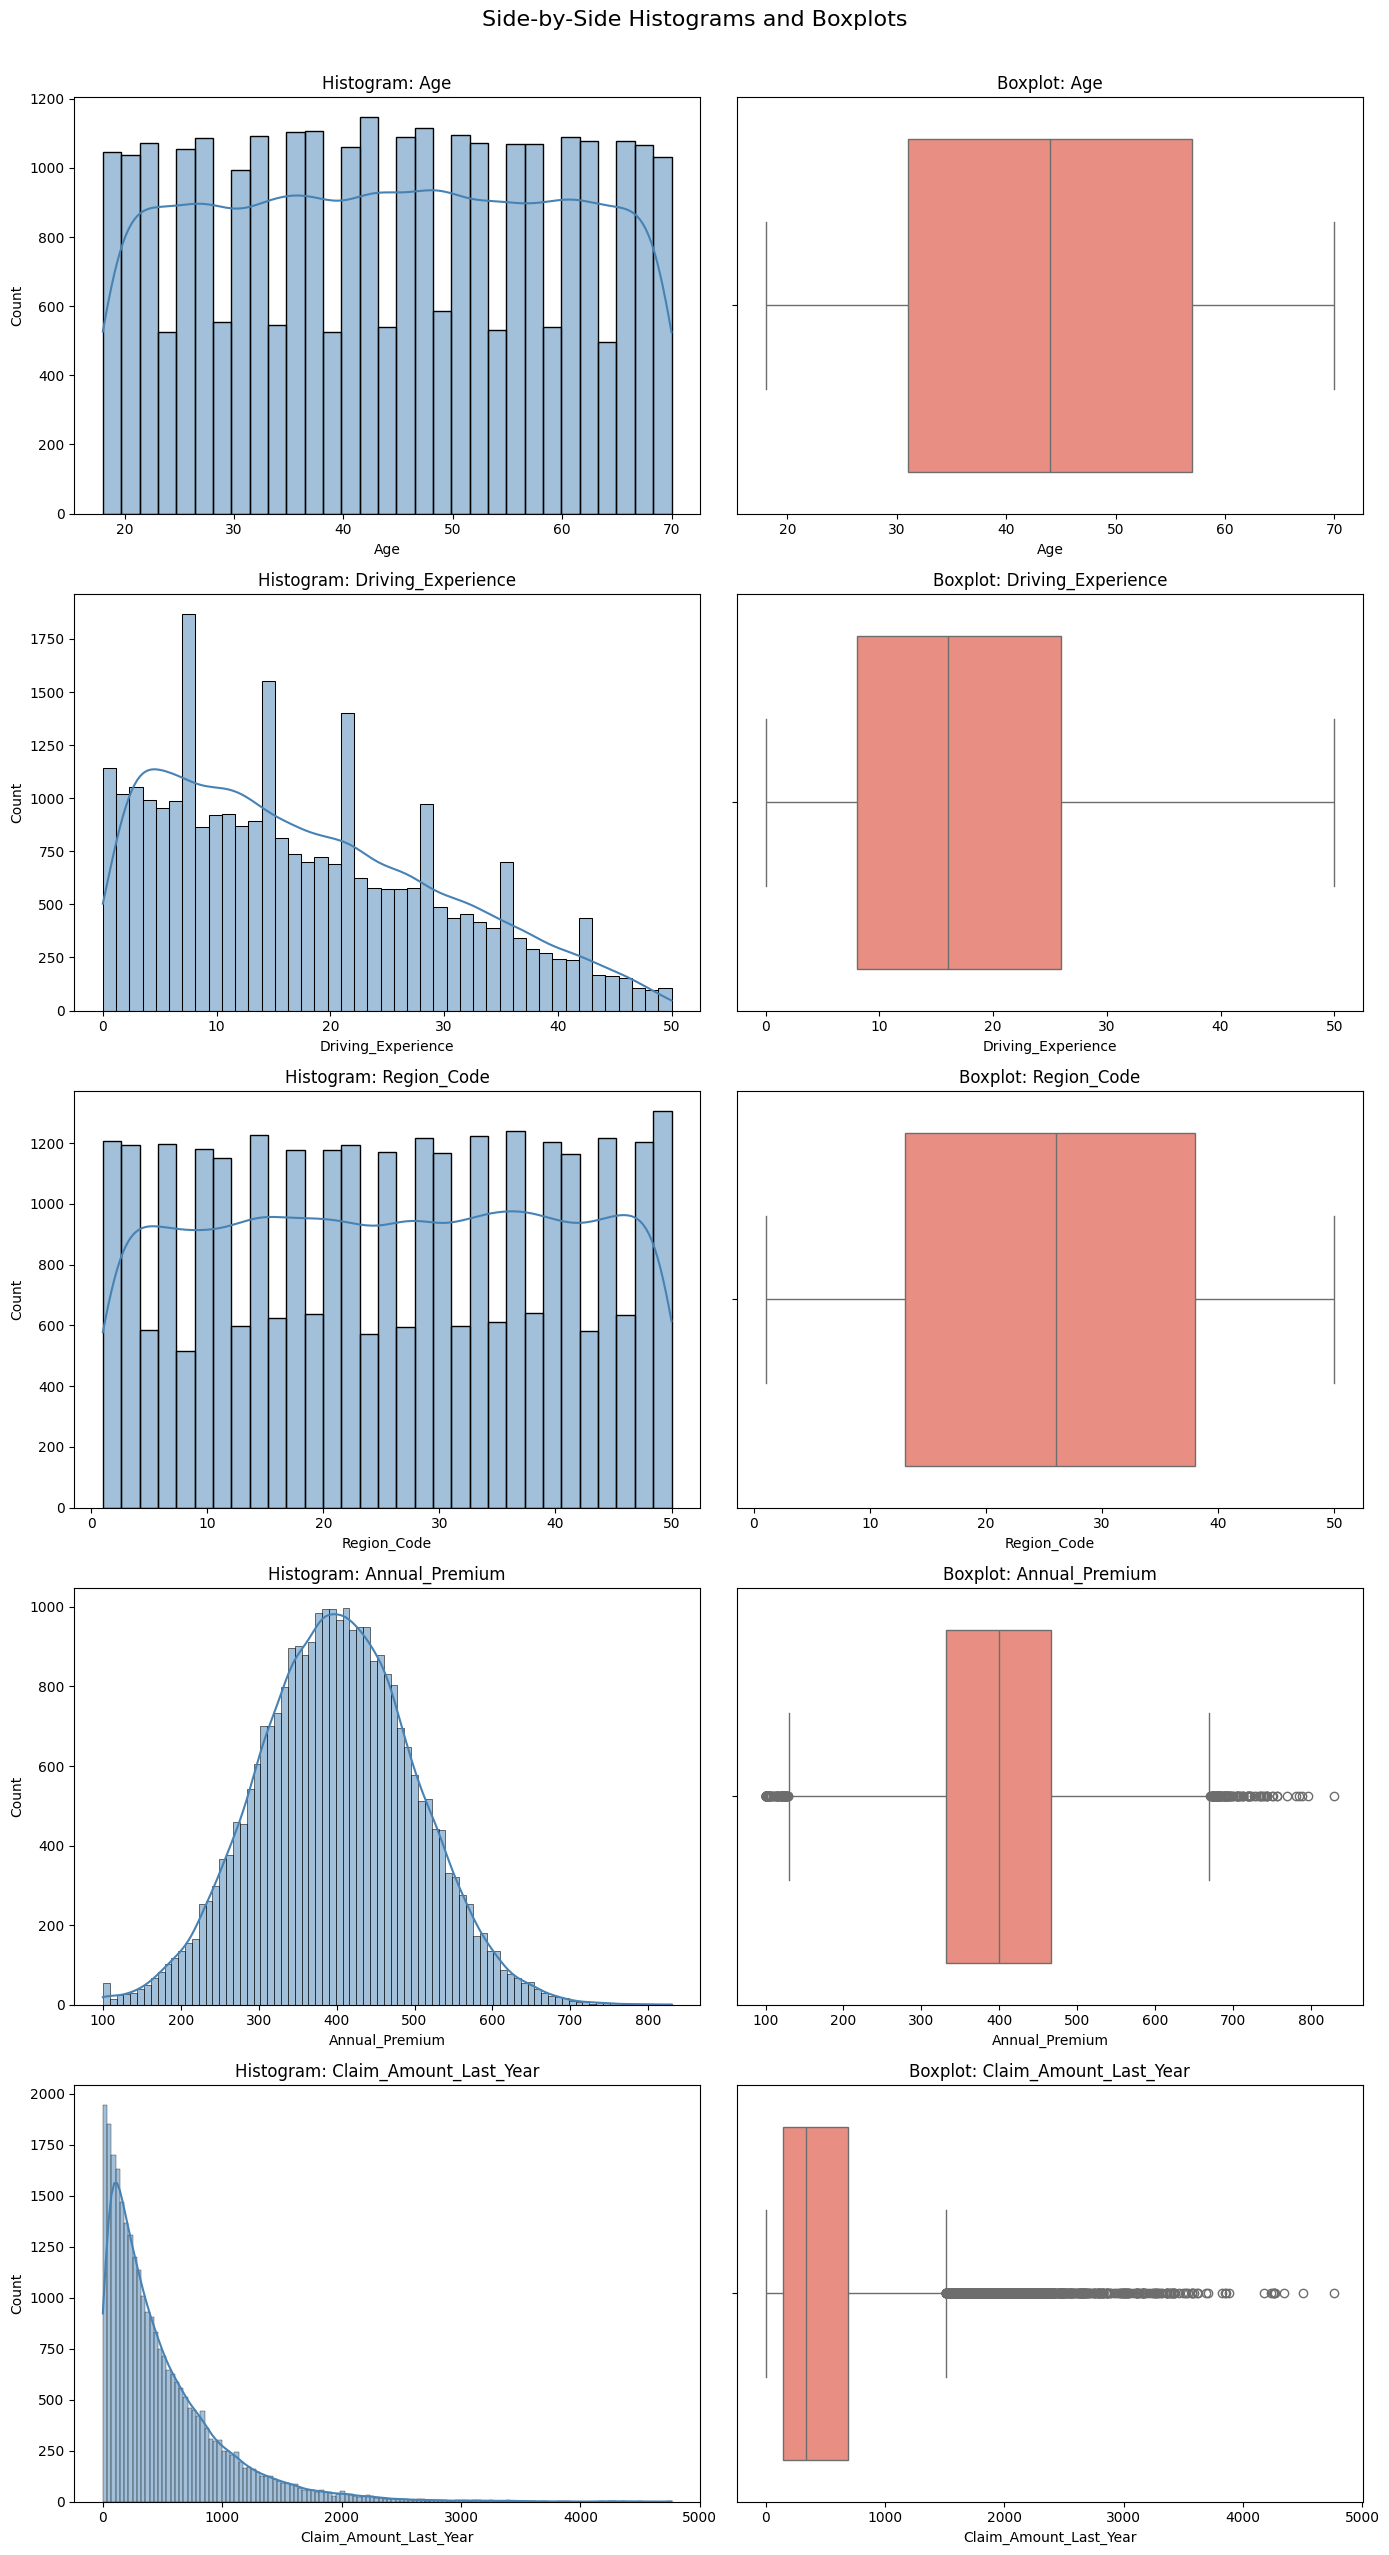

In [10]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

n_features = len(numerical_cols)
fig, axes = plt.subplots(n_features, 2, figsize=(14, 5 * n_features))

if n_features == 1:
    axes = [axes]

# Plot histograms and boxplots side by side
for i, col in enumerate(numerical_cols):
    # Histogram
    sns.histplot(data[col], kde=True, ax=axes[i][0], color='steelblue')
    axes[i][0].set_title(f'Histogram: {col}', fontsize=12)

    # Boxplot
    sns.boxplot(x=data[col], ax=axes[i][1], color='salmon')
    axes[i][1].set_title(f'Boxplot: {col}', fontsize=12)

plt.tight_layout()
plt.suptitle("Side-by-Side Histograms and Boxplots", fontsize=16, y=1.02)
plt.show()

### Categorical Features

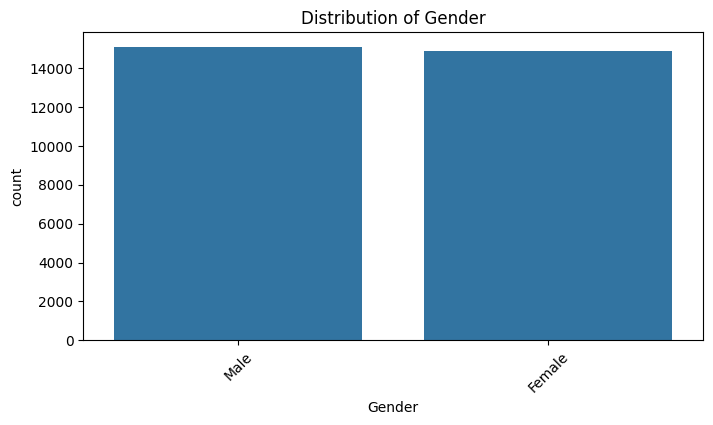

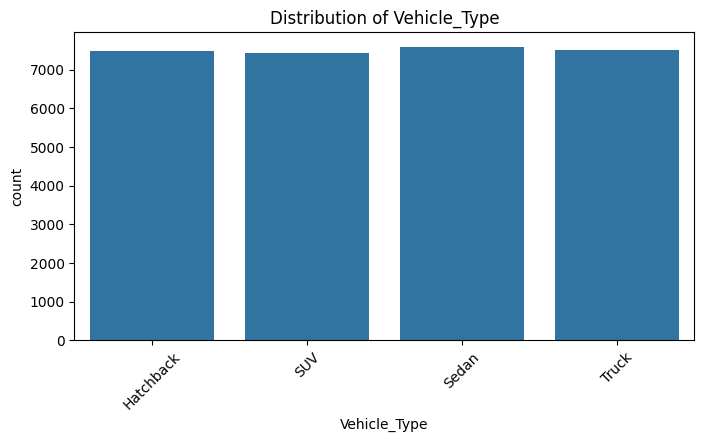

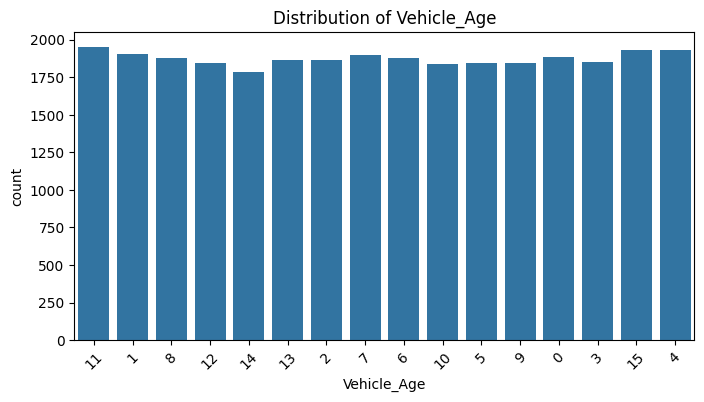

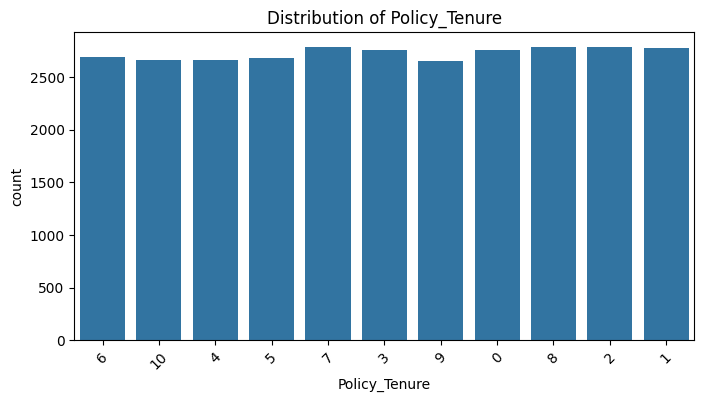

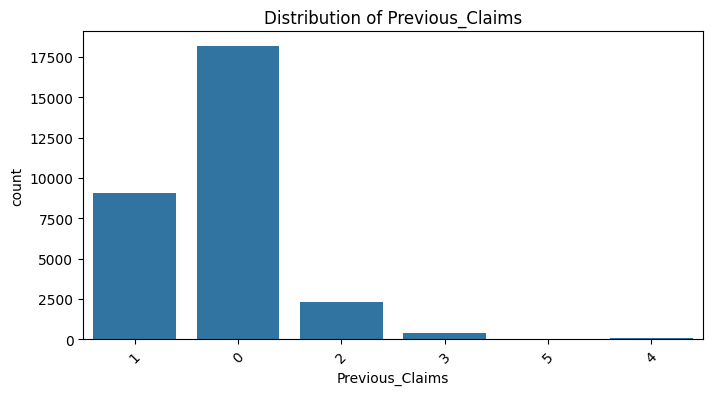

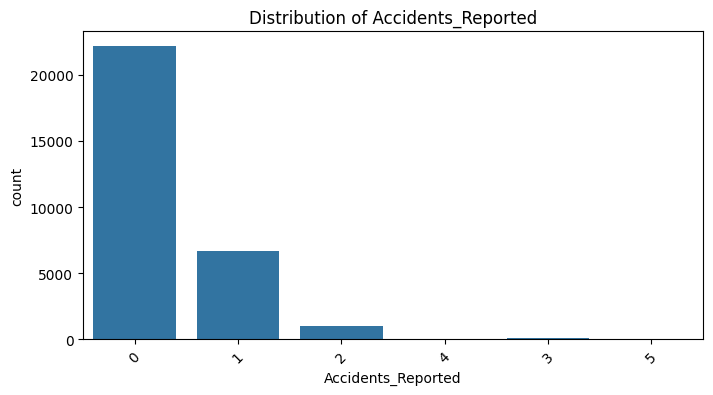

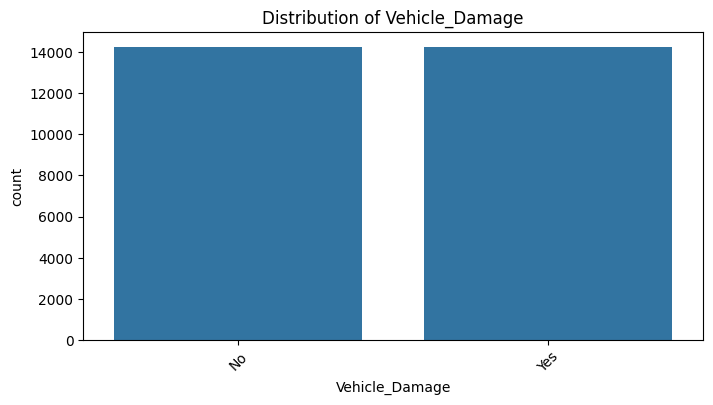

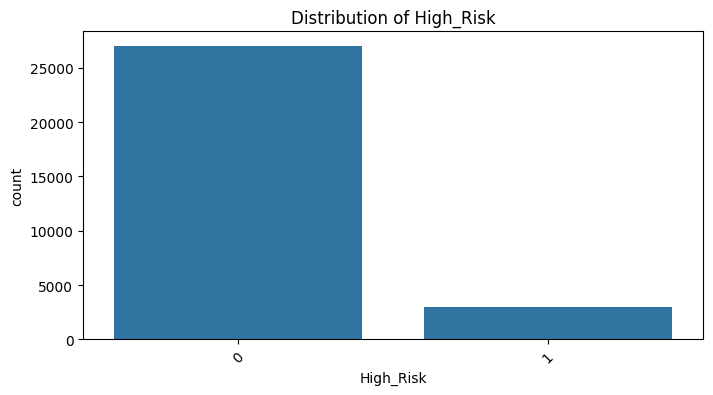

In [11]:
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=data, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

## Bivariate Analysis

### Numerical Features vs Target

### Correlations

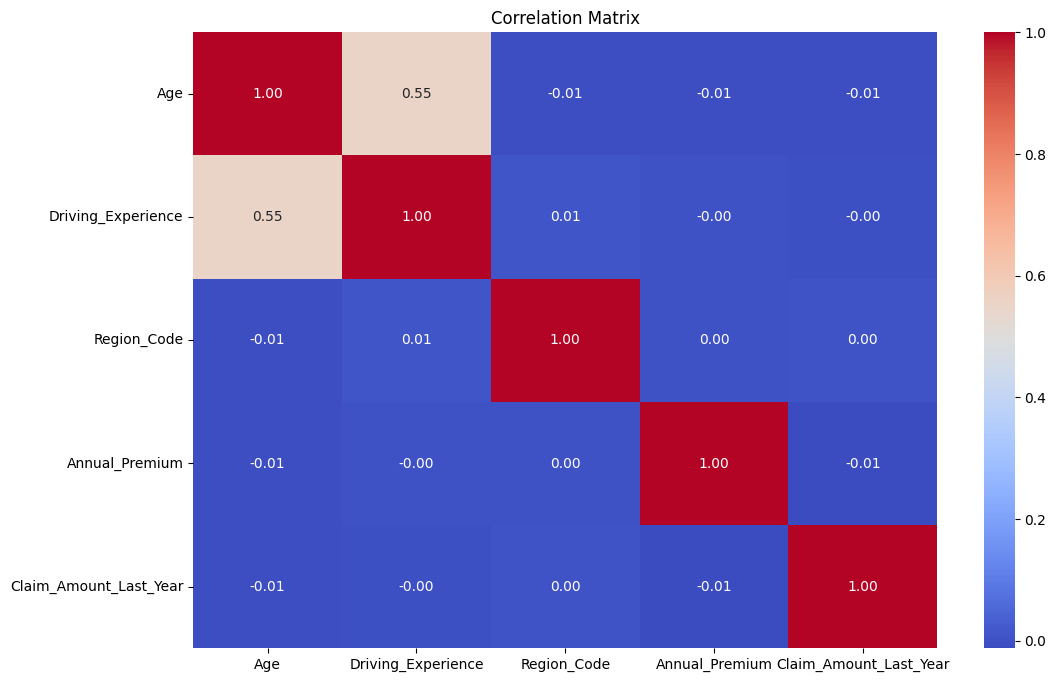

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(data[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

### Interesting Feature Relationships

ValueError: Could not interpret value `Annual_Income` for `x`. An entry with this name does not appear in `data`.

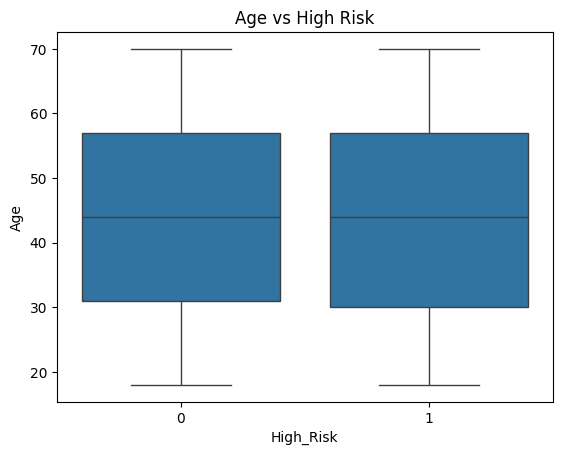

In [14]:
sns.boxplot(x='High_Risk', y='Age', data=data)
plt.title("Age vs High Risk")

sns.scatterplot(x='Annual_Income', y='Vehicle_Age', hue='High_Risk', data=data)
plt.title("Income vs Vehicle Age by Risk Category")